In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/wsh_2025/Project Codes/input datafiles/')

In [5]:
input_file = '11447650_filled_daily_data.csv'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

# set seed
torch.manual_seed(42)
np.random.seed(42)

if torch.cuda.is_available():
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)

device: cpu


Defining the RiverData custom Dataset class to load the data in:

In [6]:
class RiverData(torch.utils.data.Dataset):

  # first function is the __init__() function, which loads data from input file
  def __init__(self, df, target, datecol, seq_len, pred_len):
    self.df = df
    self.datecol = datecol
    self.target = target
    self.seq_len = seq_len # length of single sequence of input data
    self.pred_len = pred_len # length of forward-forecasting sequence

  # second function sets the index to the date column
  def setIndex(self):
    self.df.set_index(self.datecol, inplace = True)

  # third function defines the length of the input dataset, minus the
  # training sequence length minus the prediction length
  def __len__(self):
    return len(self.df) - self.seq_len - self.pred_len

  # fourth function returns a typle of a feature and a label, which is used for
  # model training. for time series, the feature is the past values for
  # training and the label are the future values to be predicted
  def __getitem__(self, idx):

    # raises warning if not enough data at index idx
    if len(self.df) <= (idx + self.seq_len + self.pred_len):
      raise IndexError(
          f'Index {idx} out of bounds for dataset size {len(self.df)}')

    # pulls values for training sequence and assigns to df_piece
    df_piece = self.df[idx:idx + self.seq_len].values

    # converts df_piece into a tensor data type
    feature = torch.tensor(df_piece, dtype = torch.float32)

    # pulls the target data
    label_piece = self.df[self.target][
        idx + self.seq_len:
        idx + self.seq_len + self.pred_len].values

    # converts label_piece to tensor data type
    label = torch.tensor(label_piece, dtype = torch.float32)

    return (feature, label)

Normalizing data:

In [7]:
df = pd.read_csv(input_file)
df.drop('SSD_st_d', axis = 1, inplace = True) # drop ssd
df.drop('Precip_in', axis = 1, inplace = True) # drop wrong precip

raw_df = df.drop('DATE', axis = 1, inplace = False)
scaler = MinMaxScaler()

# apply transformations and make new df
df_scaled = scaler.fit_transform(raw_df)

df_scaled = pd.DataFrame(df_scaled, columns = raw_df.columns)
df_scaled['DATE'] = df['DATE']

df = df_scaled

In [ ]:
df_scaled

,SSC_mg_L,Discharge_cfs,Precip_in,Turb_fnu,DATE
0,0.041308,0.044633,0.000000,0.008162,2009-12-03
1,0.032702,0.046919,0.000000,0.008562,2009-12-04
2,0.022375,0.045504,0.000000,0.008286,2009-12-05
3,0.017212,0.042565,0.024030,0.009144,2009-12-06
4,0.034423,0.052798,0.077634,0.009345,2009-12-07
...,...,...,...,...,...
5044,0.025818,0.150882,0.000000,0.010799,2023-09-25
5045,0.024096,0.146527,0.000000,0.010512,2023-09-26
5046,0.020654,0.142173,0.000000,0.010107,2023-09-27
5047,0.020654,0.139996,0.000000,0.009440,2023-09-28


In [8]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

seq_len = 14
pred_len = 1
num_features = 3

# remember: single asterix unpacks list
common_args = ['SSC_mg_L', 'DATE', seq_len, pred_len]

# pulled from beginning of df to train_size
train_dataset = RiverData(df[:train_size], *common_args)
train_dataset.setIndex()

# pulled from the end of train_size to the end of val_size
val_dataset = RiverData(df[train_size: train_size + val_size], *common_args)
val_dataset.setIndex()

# pulled from the end of train + val to the end of the df
test_dataset = RiverData(df[train_size + val_size: len(df)], *common_args)
test_dataset.setIndex()

In [9]:
# number of training examples used in one iteration to update model params
BATCH_SIZE = 492

SHUFFLE = False # order matters for time series
DATA_LOAD_WORKERS = 1

# learning rate determines step size at which params are updated while training
learning_rate = 0.007240183391544309

# adds penalty to loss function based on magnitude of model weights, preventing
# overreliance on single parameter
weight_decay = 0.000013647269057168989

In [10]:
from torch.utils.data import DataLoader

# remember: double asterix unpacks dictionary
common_args = {'batch_size': BATCH_SIZE, 'shuffle': SHUFFLE}
train_loader = DataLoader(train_dataset, **common_args)
val_loader = DataLoader(val_dataset, **common_args)
test_loader = DataLoader(test_dataset, **common_args)

Defining PyTorch LSTM model:

In [11]:
class BasicLSTMNetwork(torch.nn.Module):
  # __init__() function sets up layers and defines model params
  def __init__(self, seq_len, pred_len):
    # call base class constructor
    super().__init__()
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.num_features = num_features
    self.n_layers = 1

    # define size of hidden state
    self.n_hidden = 128

    # define layers for combining across time series
    self.lstm1 = torch.nn.LSTM(input_size = self.num_features,
                               hidden_size = self.n_hidden,
                               num_layers = self.n_layers,
                               batch_first = True)
    self.relu = torch.nn.ReLU()
    self.fc1 = torch.nn.Linear(self.n_hidden * self.seq_len, self.pred_len)

  def init_hidden(self, batchsize):
    device = next(self.parameters()).device
    hidden_state = torch.zeros(self.n_layers,
                               batchsize,
                               self.n_hidden,
                               device = device)
    cell_state = torch.zeros(self.n_layers,
                             batchsize,
                             self.n_hidden,
                             device = device)
    return hidden_state, cell_state

  # forward() function defines how forward pass computation operates
  # gradients are stored inside FC layer objects
  # each training example needs the old gradient erased
  def forward(self, x):
    batchsize, seqlen, featlen = x.size()
    self.hidden_states = self.init_hidden(batchsize)
    lstm_out, self.hidden_states = self.lstm1(x, self.hidden_states)
    lstm_out = lstm_out.contiguous().view(batchsize, -1)
    lstm_out = self.relu(lstm_out)
    lstm_out = self.fc1(lstm_out)
    return lstm_out

In [12]:
model = BasicLSTMNetwork(seq_len, pred_len)
model = model.to(device)
loss = torch.nn.MSELoss().to(device)

# adam optimizer generally best option
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             weight_decay = weight_decay)

In [ ]:
# model param check 1
for gen in model.parameters():
  print(gen.shape)

torch.Size([512, 3])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([1, 1792])
torch.Size([1])


In [ ]:
# model param check 2
for i, (f, l) in enumerate(train_loader):
  print('features shape: ', f.shape)
  print('labels shape: ', l.shape)
  break

features shape:  torch.Size([492, 14, 3])
labels shape:  torch.Size([492, 1])


In [13]:
# define metrics
import numpy as np
import matplotlib.pyplot as plt
epsilon = np.finfo(float).eps

def wape_function(y, y_pred):
    # Weighted Average Percentage Error metric in the interval [0; 100]
    y = np.array(y)
    y_pred = np.array(y_pred)
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator) * 100.0
    return wape

def nse_function(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))


def evaluate_model(model, data_loader, plot=False):
    # following line disables dropout and batch normalization if they
    # are part of the model.

    model.eval()
    all_inputs = torch.empty((0, seq_len, num_features))
    all_labels = torch.empty(0, pred_len)
    for inputs, labels in data_loader:
        all_inputs = torch.vstack((all_inputs, inputs))
        all_labels = torch.vstack((all_labels, labels))

    with torch.no_grad():
        all_inputs = all_inputs.to(device)
        outputs = model(all_inputs).detach().cpu()
        avg_val_loss = loss(outputs, all_labels)
        nse = nse_function(all_labels.numpy(), outputs.numpy())
        wape = wape_function(all_labels.numpy(), outputs.numpy())

    print(f'NSE : {nse}', end=' ')
    print(f'WAPE : {wape}', end=' ')
    print(f'Validation Loss: {avg_val_loss}')
    model.train()

    if plot is True:
        plt.figure(figsize=(16, 6))
        plt.plot(np.array(all_labels.cpu()[:400]), color='green', label='observations')
        plt.plot(np.array(outputs.cpu()[:400]), color='red', linestyle='-', label='predictions')
        metrics_text = f"NSE: {nse:.3f}\nWAPE: {wape:.3f}"
        plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.legend()
        plt.title(f'LSTM with Optuna Optimization [Sequence Length: {seq_len}]')
        plt.show()

    return avg_val_loss



So it begins:

In [14]:
num_epochs = 300
best_val_loss = float('inf')
patience = 10

for epoch in range(num_epochs):
  model.train()
  epoch_loss = []
  for batch_idx, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss_val = loss(outputs, labels)

    # calculate gradients for backpropagation
    loss_val.backward()
    # update weights based on gradients
    optimizer.step()
    # reset gradients --> avoid gradient accumulation
    optimizer.zero_grad()
    epoch_loss.append(loss_val.item())

    avg_train_loss = sum(epoch_loss) / len(epoch_loss)
    print(f'Epoch {epoch + 1}: Training Loss: {avg_train_loss}', end = ' ')
    avg_val_loss = evaluate_model(model, val_loader, device)

    # check for improvement
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      epochs_no_improve = 0

      # save best model
      torch.save(model.state_dict(), 'best_model.pth')
    else:
      epochs_no_improve += 1
      if epochs_no_improve == patience:
        print('Early stopping!')
        # load next model before stopping
        model.load_state_dict(torch.load('best_model.pth'))
        break

Epoch 1: Training Loss: 0.004948322661221027 NSE : -292.5192565917969 WAPE : 1083.6678055676452 Validation Loss: 0.06360625475645065
Epoch 1: Training Loss: 0.02936078468337655 NSE : -15.062915802001953 WAPE : 246.8752217613811 Validation Loss: 0.00348086841404438
Epoch 1: Training Loss: 0.021733128000050783 NSE : -0.7502622604370117 WAPE : 57.76590908312049 Validation Loss: 0.00037928560050204396
Epoch 1: Training Loss: 0.01877903810236603 NSE : -1.8237638473510742 WAPE : 87.42750779785108 Validation Loss: 0.0006119157187640667
Epoch 1: Training Loss: 0.016099543217569588 NSE : -0.14370429515838623 WAPE : 55.73327299612759 Validation Loss: 0.00024784321431070566
Epoch 1: Training Loss: 0.014332613907754421 NSE : -24.251577377319336 WAPE : 313.3523734329176 Validation Loss: 0.005472071003168821
Epoch 1: Training Loss: 0.013035516587219067 NSE : -14.513435363769531 WAPE : 244.35082184506638 Validation Loss: 0.0033617953304201365
Epoch 1: Training Loss: 0.011718231660779566 NSE : -0.3882

NSE : 0.8709344863891602 WAPE : 36.43211818870101 Validation Loss: 0.00030772454920224845


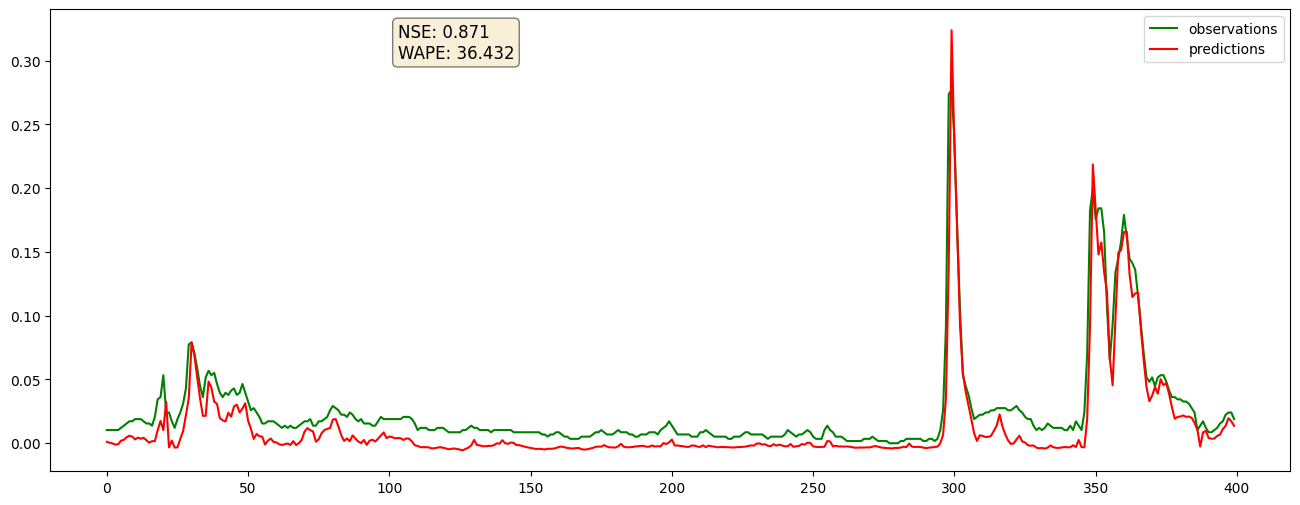

tensor(0.0003)

In [ ]:
# SEQUENCE LENGTH 7
evaluate_model(model, test_loader, plot = True)

# SEQUENCE LENGTH 14
evaluate_model(model, test_loader, plot = True)

NSE : 0.19865143299102783 WAPE : 123.29240754056782 Validation Loss: 0.001921021263115108


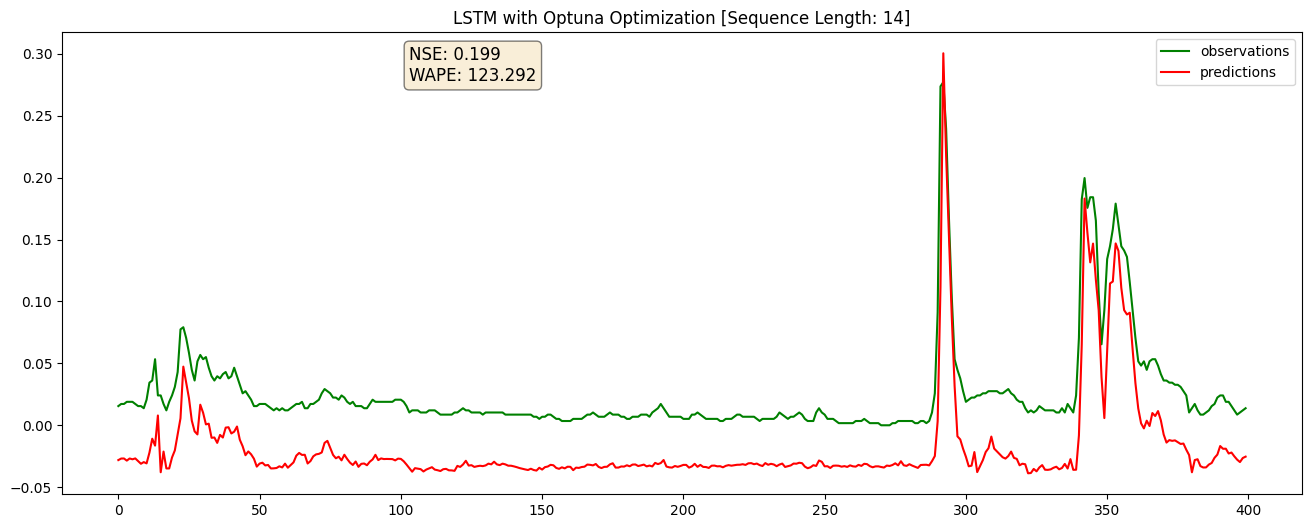

tensor(0.0019)

In [16]:
# SEQUENCE LENGTH 13
evaluate_model(model, test_loader, plot = True)

NSE : 0.19865143299102783 WAPE : 123.29240754056782 Validation Loss: 0.001921021263115108


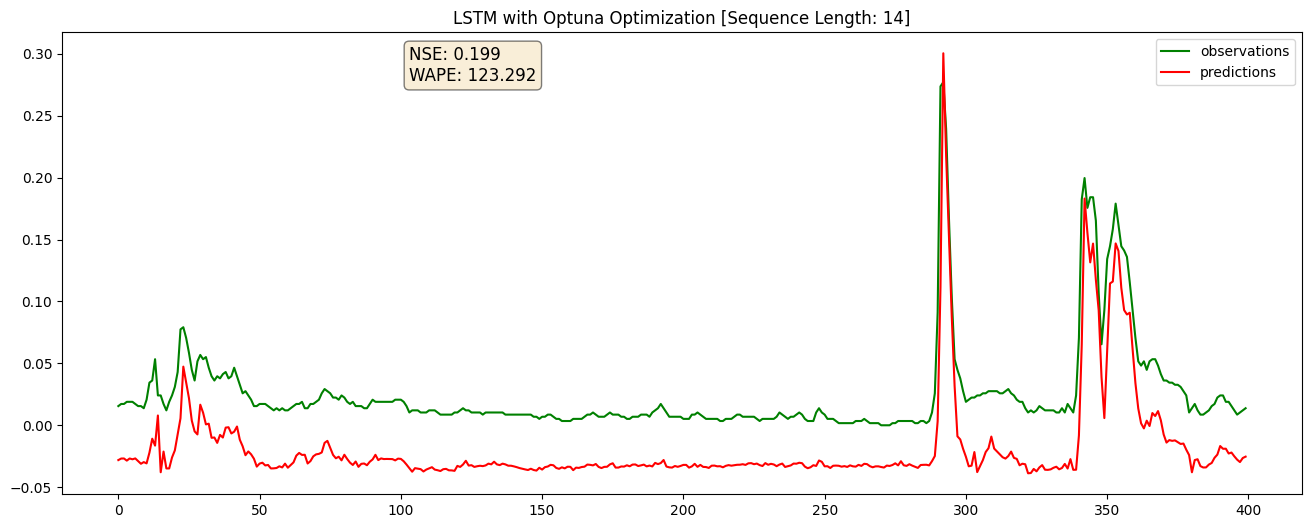

tensor(0.0019)

In [17]:
# optuna calibrated params
evaluate_model(model, test_loader, plot = True)